In [29]:
# Data Handlers
import pandas as pd
import numpy as np
from PIL import Image
from PIL import ImageOps

# Pytorch
import torch
import torch.nn as nn  # NN; networks (CNN, RNN, losses)
import torch.optim as optim  # Optimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, IterableDataset  # Dataset manager
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.functional import one_hot

# Other
import datetime
import os
from tqdm import tqdm
from pathlib import Path
from os import listdir
from fastaniso import anisodiff
from time import time


# Graphics
from matplotlib import pyplot as plt
import seaborn as sns


from skimage.metrics import structural_similarity as ssim
from sklearn.preprocessing import OneHotEncoder

# Additional modules
from dataset_creator import generate_csv
from assistive_funcs import filtering_image, check_ssim, check_gmsd, convert_to_grayscale, get_dataset_name
from csv_dataloader import get_train_test_big_data, get_train_test_small_data
from math import floor

In [30]:
# Paths
p_main_data = Path("../data")
p_models = Path("../models")

p_scv_folder = p_main_data / "csv_files" # datasets_path
p_img = p_main_data / "images"

p_noised_imgs = p_main_data / "FC_imgs_with_noise"

p_filtered_images = p_main_data / "FC_filtered_images"

p_gray_images = p_main_data / "gray_images"

In [31]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"{dataset_name = }\n{device = }")
device

device(type='cuda')

In [32]:
# Dataset
win_size = 7
step = 5
create_dataset = 1
if create_dataset:
    generate_csv(win_size=win_size, dump_to_file=5000, step=step, force_create_dataset=1, classification=True)

Borders were added, indexes were created. Passed time = 0.35s
Dataset created.               
Total spent time = 5.77s
Total samples = 146410
Dataset name 'W7_S5_L146410.csv'


In [33]:
win_size = 7
step = 5

dataset_name = get_dataset_name(win_size, step, p_scv_folder, classification=True) #r"W5_S1_L3696640.csv"
dataset_name

'classification\\W7_S5_L146410.csv'

In [34]:
def check_without_filtering():
    images_names = listdir(p_noised_imgs)
    ssim_metric = []
    gmsd_metric = []
    for name in images_names:
        ssim_metric.append(check_ssim(p_noised_imgs, p_img, name))
        gmsd_metric.append(check_gmsd(p_noised_imgs, p_img, name))
    print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
    print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
    
        
def check_after_filtering():
    ssim_metric = []
    gmsd_metric = []
    images_names = listdir(p_noised_imgs)
    for name in images_names:
        ssim_metric.append(check_ssim(p_filtered_images, p_img, name))
        gmsd_metric.append(check_gmsd(p_filtered_images, p_img, name))
    print(f"SSIM avg: {sum(ssim_metric) / len(ssim_metric)}")
    print(f"GMSD avg: {sum(gmsd_metric) / len(gmsd_metric)}")
        


In [35]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# !unzip -q /content/gdrive/MyDrive/NIR/data/FC_data/W5_S5_L146410.zip


In [36]:
class FCBlock(nn.Module):
    def __init__(self, in_len, out_len, dropout=False) -> None:
        super().__init__()
        if dropout:
            self.fc_block = nn.Sequential(
                nn.Linear(in_len, out_len),
                nn.Dropout(0.5),
                nn.BatchNorm1d(out_len),
                nn.ReLU(),
            )
        else:
            self.fc_block = nn.Sequential(
                nn.Linear(in_len, out_len),
                nn.BatchNorm1d(out_len),
                nn.ReLU(),
            )
    
    def forward(self, x):
        return self.fc_block(x)

In [37]:
class DefaultModel(nn.Module):
    def __init__(self, in_len, out_len, DP1=False, DP2=False, DP3=False, DP4=False) -> None:
        super().__init__()
        double_in_len = in_len * 2
        triple_in_len = in_len * 3

        self.structure = nn.Sequential(
            FCBlock(in_len, in_len),
            FCBlock(in_len, double_in_len, dropout=DP1),
            FCBlock(double_in_len, triple_in_len, dropout=DP2),
            FCBlock(triple_in_len, double_in_len, dropout=DP3),
            FCBlock(double_in_len, in_len, dropout=DP4),
            nn.Linear(in_len, out_len)
        )

    def forward(self, x):
        x = self.structure(x)
        return x

In [38]:
class FitModel():
    def __init__(self, model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.num_epoches = num_epoches
        self.p_scv_folder = p_scv_folder
        self.dataset_name = dataset_name
        self.batch_size = batch_size
        self.train_losses = []
        self.valid_losses = []
        self.device = device  
        
        X = [[i] for i in range(0, 256)]
        self.enc = OneHotEncoder()
        self.enc.fit(X)

    def _train(self, current_epoch):
        # loop = tqdm(enumerate(self.train_loader, start=1),
        #     leave=True,
        #     total=len(self.train_loader))
        total_loss = []

        self.model.train()
        # for batch_index, (data, targets) in loop:
        for batch_index, (data, targets) in tqdm(enumerate(self.train_loader, start=1)):
            data = data.to(device=self.device)
            targets = torch.Tensor(self.enc.transform(targets).toarray())
            targets = targets.to(device=self.device)

            scores = self.model(data)
            loss = self.criterion(scores, targets)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            total_loss.append(loss.item())
            
            # loop.set_description(f"Train epoch: {current_epoch}")
            # loop.set_postfix(loss=round(np.mean(total_loss[-batch_index:]), 2))

        self.train_losses.append(np.mean(total_loss))
        
    def _valid(self, current_epoch):
        # loop = tqdm(enumerate(self.test_loader, start=1),
        #     leave=True,
        #     total=len(self.test_loader))
        total_loss = []

        self.model.eval()
        with torch.no_grad():
            # for batch_index, (data, targets) in loop:
            for batch_index, (data, targets) in tqdm(enumerate(self.test_loader, start=1)):
                data = data.to(device=self.device)
                targets = torch.Tensor(self.enc.transform(targets).toarray())
                targets = targets.to(device=self.device)
                
                # Forward
                scores = self.model(data) # Equal to model.forward(data)
                loss = self.criterion(scores, targets)
                total_loss.append(loss.item())
                
                # loop.set_description(f"Valid epoch: {current_epoch}")
                # loop.set_postfix(loss=round(np.mean(total_loss[-batch_index]), 2))
            
        self.valid_losses.append(np.mean(total_loss))
    
    def fit(self):
        for epoch in range(self.num_epoches):
            self.train_loader, self.test_loader = get_train_test_small_data(scv_folder=self.p_scv_folder, dataset_name=self.dataset_name,
                                                                      batch_size=self.batch_size, train_size=0.8)
            self._train(epoch + 1)
            self._valid(epoch + 1)
            if self.scheduler is not None:
                self.scheduler.step()
                
    def plot_graph(self):
        sns.set()
        fig, (ax_train, ax_test) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
        fig.suptitle('Loss')

        ax_train.set_title("Train loss")
        ax_test.set_title("Valid loss")

        ax_train.set_ylabel('Loss value')
        ax_test.set_ylabel('Loss value')

        ax_train.set_xlabel("Batch")
        ax_test.set_xlabel("Batch")

        sns.lineplot(data=self.train_losses, ax=ax_train)
        sns.lineplot(data=self.valid_losses, ax=ax_test)

        plt.show()
    
    def filtering_all_images(self):
        images_names = listdir(p_noised_imgs)
        for name in images_names:
            filtering_image(self.model, p_filtered_images, p_noised_imgs, name, win_size, self.device, classification=True)


In [39]:
# Hyperparameters 
learning_rate = 0.1
num_epoches = 9
batch_size = 128


In [40]:
model = DefaultModel(in_len=(win_size ** 2), out_len=256).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.2)

In [41]:
fit_model = FitModel(model, criterion, optimizer, scheduler, p_scv_folder, dataset_name, batch_size, device, num_epoches)
fit_model.fit()

916it [00:08, 107.56it/s]
229it [00:01, 199.77it/s]
916it [00:08, 103.54it/s]
229it [00:00, 302.68it/s]
916it [00:08, 103.93it/s]
229it [00:00, 285.15it/s]
916it [00:08, 106.99it/s]
229it [00:00, 322.82it/s]
916it [00:08, 114.25it/s]
229it [00:00, 313.45it/s]
916it [00:09, 96.72it/s] 
229it [00:00, 301.88it/s]
916it [00:08, 108.34it/s]
229it [00:00, 246.91it/s]
916it [00:08, 114.49it/s]
229it [00:00, 269.89it/s]
916it [00:07, 115.59it/s]
229it [00:00, 321.36it/s]


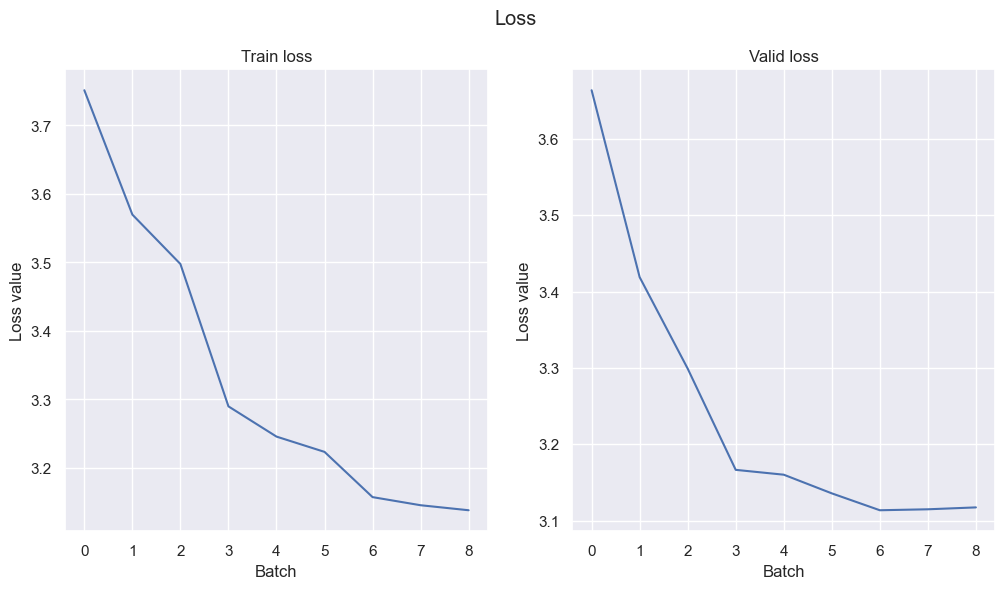

In [42]:
fit_model.plot_graph()

In [43]:
fit_model.filtering_all_images()

100%|██████████| 608/608 [00:01<00:00, 351.65it/s]


In [44]:
check_after_filtering()

SSIM avg: 0.8853771213786488
GMSD avg: 0.06387438644853231


In [45]:
check_without_filtering()

SSIM avg: 0.4955439958035946
GMSD avg: 0.13382857989155486


In [46]:
# p_img = p_raw_image / list_images[2]
# img_arr = np.array(ImageOps.grayscale(Image.open(p_img)))
# niters = [1, 2, 5, 10, 20]
# kappa = [1, 5, 10, 50, 100]
# for i in niters:
#     for k in kappa:
#         img_filtered = anisodiff(img_arr, niter=i, kappa=k)
#         img_filtered = img_filtered.astype(np.uint8)
#         Image.fromarray(img_filtered).save(f"{p_img}_I{i}_K{k}.jpg")